# Introduction

Particles that are advected onto land grid cells can get stuck. The goal of this notebook is to add a current boundary normal to the coastline so that particles that would land on a land grid cell are pushed away. The methodoligy behind the calculations follows an example provided by Iury Simoes-Sousa from WHOI.

# Imports

In [1]:
# system
import sys
import os
from   importlib import reload

# maths
import numpy  as np
import xarray as xr

# plotting
import matplotlib.pyplot as pyp
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature

# parcels
import parcels

In [2]:
sys.path.append(os.path.abspath('../execute'))

In [3]:
import kernels
import execute_PARCELS as exP
from fieldset_vars import FieldsetVariable

## Reload Custom Libraries

In [4]:
reload(exP)
reload(kernels)

<module 'kernels' from '/home/colin_beyers/lagrangian_drifts/execute/kernels.py'>

# Data

In [5]:
ds = xr.open_dataset('/home/colin_beyers/data/WW3-total_currents-expansion_fan.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 5689, latitude: 351, longitude: 501)
Coordinates:
  * longitude  (longitude) float32 220.0 220.1 220.1 220.2 ... 249.9 249.9 250.0
  * latitude   (latitude) float32 25.5 25.56 25.62 25.68 ... 46.38 46.44 46.5
  * time       (time) datetime64[ns] 2020-07-07 ... 2021-03-01
Data variables:
    ucur       (time, latitude, longitude) float32 ...
    vcur       (time, latitude, longitude) float32 ...
Attributes: (12/16)
    WAVEWATCH_III_version_number:     7.14
    WAVEWATCH_III_switches:           NOGRB SCRIP SCRIPNC TRKNC DIST MPI PR3 ...
    SIN4 namelist parameter BETAMAX:  1.42
    product_name:                     ww3.field.nc
    area:                             GLOBAL GRID
    latitude_resolution:              0.
    ...                               ...
    easternmost_longitude:            250.
    minimum_altitude:                 -12000 m
    maximum_altitude:                 9000 m
    altitude_resolution:              n/a
    start_date:                       2020-01-01 00:00:00
    stop_date:                        2020-04-20 07:00:00

# Function

In [6]:
def coastal_boundary(ds, u_var='U', v_var='V', lon_dim='lon', lat_dim='lat', rolling_window=3, threshold=2000, time_dim='time'):
    """
    Create an artificial coastal boundary from U and V water velocity components at a single time step 
    following an example provided by Iury Simoes-Sousa.
    
    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing U and V water velocity components.
    u_var : str, optional
        Name of the U velocity component in the dataset. Default is 'U'.
    v_var : str, optional
        Name of the V velocity component in the dataset. Default is 'V'.
    lon_dim : str, optional
        Name of the longitude dimension in the dataset. Default is 'lon'.
    lat_dim : str, optional
        Name of the latitude dimension in the dataset. Default is 'lat'.
    rolling_window : int, optional
        The window size for rolling mean used to smooth the boundary. Default is 3.
    threshold : float, optional
        The threshold for velocity magnitude to define significant boundaries. Default is 2000.
    time_dim : str, optional
        The name of the time dimension. Default is 'time'.
        
    Returns:
    --------
    boundary : xarray.Dataset
        Dataset containing the smoothed U and V velocity components for the artificial boundary at the single time step.
    norm : xarray.DataArray
        The normalized velocity magnitude used to create the boundary at the single time step.
    """
    # Select the first time step to optimize computation speed
    ds_timestep = ds.isel({time_dim: 1})

    # Create landmask by setting NaN values over land (assuming that land regions have NaN velocities)
    landmask = (ds_timestep[u_var] - ds_timestep[u_var]).fillna(1)

    # Differentiate along longitude and latitude to create artificial boundary velocity components
    u_boundary = -(1e3 * landmask.differentiate(lon_dim))
    v_boundary = -(1e3 * landmask.differentiate(lat_dim))

    # Calculate the magnitude (norm) of the velocity vectors
    norm = np.sqrt(u_boundary**2 + v_boundary**2)

    # Apply the threshold to filter out small velocity magnitudes
    norm = norm.where(norm > threshold)

    # Normalize U and V components
    u_boundary = (u_boundary / norm).fillna(0)
    v_boundary = (v_boundary / norm).fillna(0)

    # Apply a rolling mean to smooth the boundary
    boundary = xr.Dataset({
        u_var: u_boundary,
        v_var: v_boundary
    }).rolling({lon_dim: rolling_window, lat_dim: rolling_window}, center=True).mean()

    return boundary, norm

In [7]:
def dimmentionalize(ds, ds_boundary):
    """
    Upscale ds_boundary to have the same time steps as ds.

    Parameters:
    -----------
    ds : xarray.Dataset
        The original dataset with the desired time steps.
    ds_boundary : xarray.Dataset
        The dataset with artificial boundary data to be upscaled.

    Returns:
    --------
    ds_boundary_upscaled : xarray.Dataset
        The upscaled dataset with the same time steps as ds.
    """
    
    # Get the number of time steps in the original dataset
    num_time_steps = ds.sizes['time']

    # Create a new dataset with the same time steps as ds
    ds_boundary_upscaled = xr.concat([ds_boundary] * num_time_steps, dim='time')

    # Reset the time dimension to match the original dataset's time coordinates
    ds_boundary_upscaled['time'] = ds['time']

    return ds_boundary_upscaled

In [9]:
boundary, norm = coastal_boundary(ds, u_var='ucur', v_var='vcur', lon_dim='longitude', lat_dim='latitude', rolling_window=3, threshold=2000, time_dim='time')

In [10]:
ds_boundary = dimmentionalize(ds, boundary)

In [11]:
ds_boundary

<xarray.Dataset>
Dimensions:    (longitude: 501, latitude: 351, time: 5689)
Coordinates:
  * longitude  (longitude) float32 220.0 220.1 220.1 220.2 ... 249.9 249.9 250.0
  * latitude   (latitude) float32 25.5 25.56 25.62 25.68 ... 46.38 46.44 46.5
  * time       (time) datetime64[ns] 2020-07-07 ... 2021-03-01
Data variables:
    ucur       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vcur       (time, latitude, longitude) float32 nan nan nan ... nan nan nan

## Saving

In [12]:
ds_boundary.to_netcdf('/home/colin_beyers/data/WW3-coastal_boundary-07072020_01032021.nc')

# Plotting

In [10]:
def plot_currents_with_quivers(ds, u_var='U', v_var='V', lon_var='lon', lat_var='lat', step=2):
    """
    Plot ocean currents using quivers, with coastlines and georeferenced data.

    Parameters:
    -----------
    ds : xarray.Dataset
        Dataset containing U and V water velocity components.
    u_var : str, optional
        Name of the U velocity component in the dataset. Default is 'U'.
    v_var : str, optional
        Name of the V velocity component in the dataset. Default is 'V'.
    lon_var : str, optional
        Name of the longitude variable in the dataset. Default is 'lon'.
    lat_var : str, optional
        Name of the latitude variable in the dataset. Default is 'lat'.
    step : int, optional
        Step size to downsample the data for quiver plotting. Default is 5.
    """
    # Extract U, V, longitude, and latitude values
    U = ds[u_var]
    V = ds[v_var]
    lon = ds[lon_var]
    lat = ds[lat_var]

    # Set up the map with coastlines and a projection
    fig, ax = pyp.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
    
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Georeference the data and plot quivers
    q = ax.quiver(lon[::step], lat[::step], U[::step, ::step], V[::step, ::step],
                  scale=50, headwidth=3, transform=ccrs.PlateCarree())

    # Add quiver key (scale bar)
    ax.quiverkey(q, 0.1, 0.1, 1, '1 m/s', labelpos='E', coordinates='figure')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False  # Disable top and right labels

    pyp.title('Currents Quiver Plot')
    pyp.show()

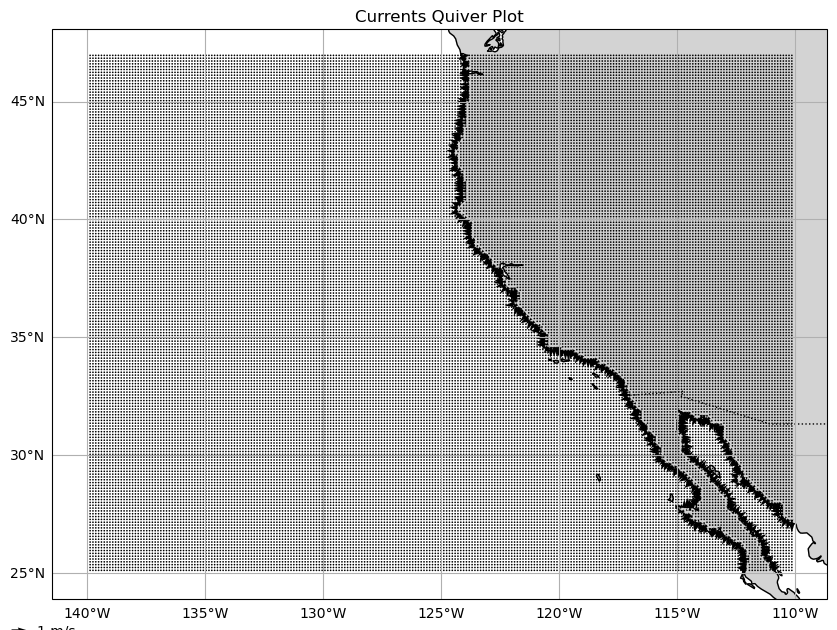

In [11]:
plot_currents_with_quivers(boundary)

The dataset `ds_boundary` contains just the boundary for this region at the cllc grid resolution. *This boundary current dataset only depends on the grid resolution, not the actual current content*. Therefore, it can be added to any current dataset that uses the same grid to add a coastal boundary. This will be very important as the currents that will be used to advect particles will change; however the grid will not.

The boundary currents are on grid cells that were previously land cells, so no data from the origional file should be overwritten.

# Combining Datasets

There is no `xarray` function to combine these datasets in the way that needs to be done here. The best approach is to add them to eachother directly using arithmatic operations.

In [12]:
combined_dataset = ds + ds_boundary

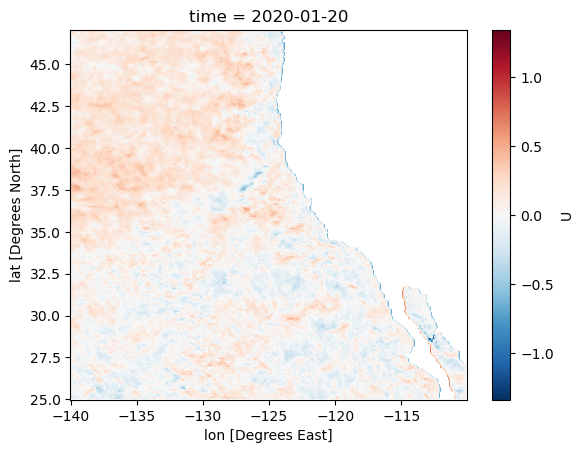

In [13]:
combined_dataset['U'].isel(time=0).plot()

In [19]:
combined_dataset.to_netcdf('/home/colin_beyers/data/CCS-U(wcb),V(wcb),mag-01202020_20292021.nc')

# Implementation to execute_PARCELS.py

The goal of this section is to implement coastal boundaries into the existing PARCELS workflow. It takes a considerable amount of time (~mintues) for the boundary current, dimmentionalization, and arithmatic addition to be performed for this relatively small region. Therefore, it is likely best if these operations happen outside of the PARCELS execution, as short model runs only take on the order of minutes to run. However, it would be best if the code is structured in such a way that these calculations *could* happen when executing PARCELS if it has not already been done.

To maintain modularity, a new set of configurations are made that specify if a coastal boundary should get used, and if so, where the boundary current dataset lives.

In [79]:
config   = exP.load_config('/home/colin_beyers/lagrangian_drifts/simulations/new_fieldset_test/config.json')
fieldset = exP.create_fieldset(config)

2024-10-04 13:56:30,668 - INFO - Loading configuration from /home/colin_beyers/lagrangian_drifts/simulations/new_fieldset_test/config.json
2024-10-04 13:56:30,670 - INFO - Including a coastal boundary.
2024-10-04 13:56:30,670 - WARNING - No coastal boundary path provided. Assuming main path includes the coastal boundary already.
2024-10-04 13:56:30,697 - INFO - Fieldset created with filenames: /home/colin_beyers/data/CCS-U(wcb),V(wcb),mag-01202020_20292021.nc


In [84]:
def plot_field(fieldset):
    fieldset.computeTimeChunk(time=0, dt=1)

    # Create a GeoAxes subplot
    fig, ax = pyp.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot the field data
    pcm = ax.pcolormesh(fieldset.U.grid.lon, 
                        fieldset.U.grid.lat, 
                        fieldset.U.data[0, :, :],
                        transform=ccrs.PlateCarree(),
                        zorder=0)

    # Add coastlines and land features
    # ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.LAND,
    #                facecolor='tan',
    #                zorder=1)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = pyp.FuncFormatter(lambda lon, _: f'{lon:.0f}°E' if lon > 0 else f'{-lon:.0f}°W')
    gl.yformatter = pyp.FuncFormatter(lambda lat, _: f'{lat:.0f}°N' if lat > 0 else f'{-lat:.0f}°S')

    # Set labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("U-Component of Velocity")

    # Add colorbar
    cbar = pyp.colorbar(pcm, ax=ax, shrink=0.9)
    cbar.set_label("Velocity (m/s)")

    pyp.show()
    return

/home/colin_beyers/miniconda3/envs/parcels_working/lib/python3.12/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colin_beyers/miniconda3/envs/parcels_working/lib/python3.12/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


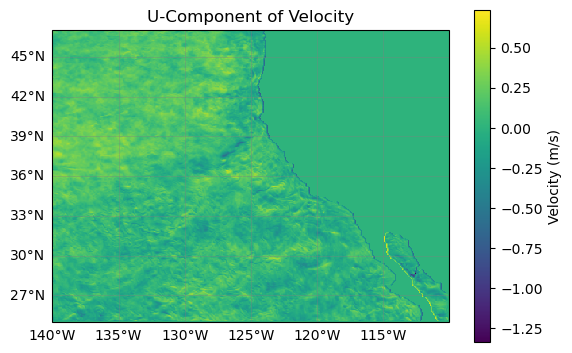

In [85]:
plot_field(fieldset)